In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.sparse import csc_matrix, csr_matrix

In [8]:
def load_movielens(mean_adjust = 'user'):
    '''Loads movielens set into a Dataframe. Adjusted rating is user by default'''
    path = 'ml-latest-small\\'
    df = pd.read_csv(path + 'ratings.csv')
    movie_xref = pd.read_csv(path + 'movies.csv')
    users = df.groupby('userId').mean()['rating'].reset_index()
    users['user_mean_rating'] = users['rating']
    users['uid'] = users.index
    users.drop('rating',inplace=True,axis=1)
    df = df.merge(users,left_on='userId',right_on='userId')
    movies = df.groupby('movieId').mean()['rating'].reset_index()
    movies['movie_mean_rating'] = movies['rating']
    movies = movies.merge(movie_xref,left_on='movieId',right_on='movieId')
    movies.drop('rating',inplace=True,axis=1)
    movies['mid'] = movies.index
    df = df.merge(movies,left_on='movieId',right_on='movieId')
    if mean_adjust == 'user':
        df['adjusted_rating'] = df['rating'] - df['user_mean_rating']
    elif mean_adjust == 'movie':
        df['adjusted_rating'] = df['rating'] - df['movie_mean_rating']
    return df

def test_sparse(sparse_matrix):
    n = sparse_matrix.nnz
    s = sparse_matrix.shape
    return 1-n/(s[0]*s[1])

In [9]:
df = load_movielens()
users_list = df['uid']
movies_list = df['mid']
ratings_list = df['rating']
df_sparse = csr_matrix((ratings_list,(users_list,movies_list)))

# Naive Bayes

In [6]:
def calculate_priors(df):
    m_ct = df.groupby('mid').count()['uid'].reset_index()
    mr_ct = df.groupby(['mid','rating']).count()['uid'].reset_index()
    total_ct = m_ct.merge(mr_ct,left_on='mid',right_on='mid')
    total_ct['prob'] = total_ct['uid_y']/total_ct['uid_x']
    return total_ct[['mid','rating','prob']]

def calculate_priors_sparse(df_sparse,laplacian = None):
    '''laplacian should be a floating point'''
    '''This takes a sparse matrix which has as columns the set of items to be rated'''
    '''The rows are each one user.'''
    '''Nonzero entries are ratings of items they have rated'''
    
    num_cols = df_sparse.shape[1]
    all_ratings = list(set(df_sparse.data))
    all_ratings = all_ratings
    all_ratings = sorted(all_ratings)
    num_ratings = len(all_ratings)
    ct_df = np.zeros((num_cols,num_ratings))

    for c in range(num_cols):
        #counts the number of unique ratings (per column) and how many times that rating occurred
        unq,cts = np.unique(df_sparse[:,c].toarray(),return_counts=True)
        d = dict(zip(unq, cts))
        d = {k:v for k,v in d.items() if k > 0}
        rating_dict = {rating:0 for rating in all_ratings}
        for k,v in d.items():
            rating_dict[k] = v
        #d = {k:v for k,v in d.items() if k!=0}
        ct_df[c] = [i[1] for i in sorted(rating_dict.items(),key=lambda x: x[0])]
    #This dataframe now has rows which are films, columns which are ratings, and each entry has the number of times
    #which that particular rating occurred for that particular film
    ct_df = pd.DataFrame(ct_df)
    ct_df.columns = all_ratings
    numerator_cols = ct_df.columns
    ct_df['rowsum'] = ct_df.sum(axis=1)

    if laplacian is not None:
        ct_df[numerator_cols] = ct_df[numerator_cols].fillna(0) + laplacian
        ct_df['rowsum'] = ct_df['rowsum'].fillna(0) + laplacian * len(numerator_cols)
    ct_df = ct_df.apply(lambda x: x/x.rowsum,axis=1)
    ct_df = ct_df.drop('rowsum',axis=1)
    ct_df = ct_df.unstack().reset_index()
    ct_df.columns = ['rating','mid','prob']
    return ct_df

#Will need to fix this similarly to the above
def calculate_conditional(df,rating_vs,rating_k,j,k,laplacian = None):
    '''
    df is the sparse dataframe containing the data to be trained/rated
    rating_vs is the rating that we're comparing against for the conditional - 
        P(r_uk | r_uj = v_s), what's the likelihood that we observed rating r_uk for item k (user u) given that
        user u gave item j the rating v_s
    '''
    total_users = df.shape[0]
    df_j = df[:,j]
    #Find set of users who rated item j rating
    users = (df_j == rating_vs).nonzero()[0]
    num_users = len(users)
    #Of those users, how many rated item k the same as the original user?
    df_k = df_sparse[users,k]
    nz = df_k.nonzero()
    nzk = df_k[nz[0]].toarray()
    unq,cts = np.unique(nzk,return_counts=True)
    ct = []

    d = dict(zip(unq, cts))
    d = {k:v for k,v in d.items() if k!=0}
    ct.append(d)
    #This dataframe now has rows which are films, columns which are ratings, and each entry has the number of times
    #which that particular rating occurred for that particular film
    ct_df = pd.DataFrame(ct)
    numerator_cols = ct_df.columns
    ct_df['rowsum'] = ct_df.sum(axis=1)

    if laplacian is not None:
        ct_df[numerator_cols] = ct_df[numerator_cols].fillna(0) + laplacian
        ct_df['rowsum'] = ct_df['rowsum'].fillna(0) + laplacian * total_users
    try:
        retval = (ct_df[rating_vs].values/ct_df['rowsum'].values)[0]
    except:
        retval = 1/total_users
    return retval
    
def calculate_rating(df,user,item,laplacian = None):
    '''
    df: sparse array (csc?) containing the data to be predicted
    user is index of user to look at
    item is item to be rated
    
    for all items that the user rated, we need to see, for each rating possible to use,
    what the likelihood is that user rated item, that rating. In order to do so, we use the formula:
    
    P(r_uj = v_s | Observed ratings of user u) is proportional to P(r_uj = v_s) * PI(P(r_uk | r_uj = v_s) for k in I_u)
    Where I_u is the set of items that user u has rated
    P(r_uj = vs) is called the prior probability, and we'll need to calculate that for each item first
    P(r_uk | r_uj = v_s) is called the conditional probability.
    '''
    
    #priors contains the prior probabilities for all items
    #for a given item, it's the list of all ratings and what ratio, 
    #for each rating for that item, what was the likelihood it occurred
    priors = calculate_priors_sparse(df,laplacian = laplacian)
    vals = list(set(df.data))
    num = 0
    denom = 0
    user_items = df[user,:].nonzero()[1]
    for i in range(len(vals)):
        vs = vals[i]
        try:
            prior = priors.loc[(priors['mid']==item)&(priors['rating']==vs),'prob'].values[0]
        except:
            prior = 0
            continue
        mult = 1
        for k in user_items:
            user_rating = df[user,k]
            conditional = calculate_conditional(df,vs,user_rating,item,k,laplacian = laplacian)
            mult = mult * conditional 
            if np.isnan(conditional or np.isnan(prior)):
                print('vs: %0.3f rating: %0.3f item: %i k: %i')
        num += vs*prior*mult
        denom += prior * mult
    return num/denom

def print_user_movies(df,user):
    movies = df.loc[df['uid']==user,'title']
    print(movies)

In [100]:
test = [
    [1,-1,1,-1,1,-1],
    [1,1,0,-1,-1,-1],
    [0,1,1,-1,-1,0],
    [-1,-1,-1,1,1,1],
    [-1,0,-1,1,1,1]
]
test_array = np.array(test)
test_sparse = csc_matrix(test_array)

In [134]:
p = calculate_priors_sparse(df_sparse,laplacian=0.8)

In [135]:
r = calculate_rating(df_sparse,2,1,laplacian = 0.8)
print(r)

3.98558709162


In [136]:
r = calculate_rating(df_sparse,2,321,laplacian=0.8)
print(r)

4.00000000244


In [137]:
r = calculate_rating(df_sparse,2,595,laplacian=0.8)
print(r)

2.99619678703


In [20]:
r = calculate_rating(df_sparse,580,1,laplacian=0.8)
print(r)

3.66251781122


# Latent Factor Models

In [88]:
def construct_factors(df_sparse,num_factors):
    '''Constructs the num_factors user factors and item factors for the sparse matrix'''
    m = df_sparse.shape[0]
    n = df_sparse.shape[1]
    U = np.random.rand(m,num_factors)
    V = np.random.rand(n,num_factors)
    return U,V

def error(df_sparse,U,V):
    '''Calculates the matrix portion of the error term'''
    d = df_sparse.nonzero()
    rows = d[0].reshape(1,-1).flatten()
    cols = d[1].reshape(1,-1).flatten()
    e = df_sparse[d] - np.matmul(U,V.T)[d]
    e = np.asarray(e).flatten()
    e = csc_matrix((e,(rows,cols)))
    return e

def frobenius_norm(df_sparse,U,V):
    e = error(df_sparse,U,V)
    e = e.power(2)
    return e.sum()

def cost_function(df_sparse,U,V,l):
    '''Calculates the cost function to minimize, l is the regularization term'''
    e = frobenius_norm(df_sparse,U,V)
    usum = np.square(U).sum()
    vsum = np.square(V).sum()
    J = 0.5 * e + (l/2)*usum + (l/2)*vsum
    return J

def update_factors(df_sparse,U,V,l,alpha):
    '''alpha is learning rate, l is regularization parameter'''
    nz = df_sparse.nonzero()
    E = error(df_sparse,U,V)
    U_temp = U*(1-alpha * l) + alpha * (E * V)
    V_temp = V*(1-alpha * l) + alpha * (E.T * U)
    return U_temp,V_temp

def fit(df_sparse,num_factors,learning_rate,regularization_rate):
    U,V = construct_factors(df_sparse,num_factors)
    J = cost_function(df_sparse,U,V,regularization_rate)
    prev = J
    iter_ctr = 0
    while True:
        iter_ctr += 1
        U,V = update_factors(df_sparse,U,V,regularization_rate,learning_rate)
        J = cost_function(df_sparse,U,V,regularization_rate)
        pct_change = J/prev-1
        if abs(pct_change) < 0.001 or iter_ctr > 1000:
            break
        prev = J
    return U,V
    

In [89]:
U,V = fit(df_sparse,10,0.0001,0.8)
pred_rat = np.matmul(U,V.T)

In [81]:
e = error(df_sparse,U,V)

In [82]:
print(df_sparse[0,30])
print(e[0,30])
print(pred_rat[0,30])

2.5
0.0479521599001
2.4520478401


In [83]:
cost_function(df_sparse,U,V,l)

54999.428332574898

In [84]:
e = error(df_sparse,U,V)

# Split into Train-Test Sets

In [98]:
from numpy.random import choice
from scipy.sparse import lil_matrix

def train_test_split(sparse_matrix,pct):
    '''Splits a sparse matrix into two sets - a train set and a test set'''
    nz_coord = list(zip(*sparse_matrix.nonzero()))
    nz_coord_array = np.array(nz_coord)
    num_rand = int(np.floor(len(nz_coord)*(pct/100.0)))
    n = len(nz_coord)
    c = choice(n,size=num_rand,replace=False)
    rows = nz_coord_array[c][:,0]
    cols = nz_coord_array[c][:,1]
    vals = np.array(sparse_matrix[rows,cols]).flatten()
    train = sparse_matrix.copy()
    test = lil_matrix(train.shape)
    test[rows,cols] = vals
    test = test.tocsr()
    train[rows,cols] = 0
    train.eliminate_zeros()
    return train,test

In [93]:
train,test = train_test_split(df_sparse,5)

In [94]:
test

<671x9066 sparse matrix of type '<class 'numpy.float64'>'
	with 5000 stored elements in Compressed Sparse Row format>

In [95]:
U,V = fit(train,10,0.0001,0.8)
pred_rat = np.matmul(U,V.T)

In [96]:
e = error(test,U,V)

In [97]:
e

<671x9057 sparse matrix of type '<class 'numpy.float64'>'
	with 5000 stored elements in Compressed Sparse Column format>

# Playing With Dimensionality Reduction

In [4]:
df_sparse

<671x9066 sparse matrix of type '<class 'numpy.float64'>'
	with 100004 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.cluster import MiniBatchKMeans

In [13]:
inertia = []
for i in range(2,51):
    num_clusters = i
    km = MiniBatchKMeans(num_clusters)
    km.fit(df_sparse)
    inertia.append(km.inertia_)

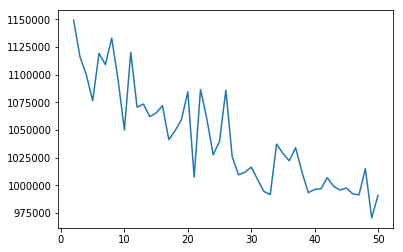

In [14]:
plt.plot(list(range(2,51)),inertia)
plt.show()

In [15]:
num_clusters = 20
km = MiniBatchKMeans(num_clusters)
labels = km.fit_predict(df_sparse)

In [28]:
user_ids = pd.DataFrame(sorted(df['uid'].unique()),columns=['uid'])
user_ids['cluster'] = labels

In [33]:
df = df.merge(user_ids,left_on='uid',right_on='uid')

In [34]:
cluster_list = df['cluster']
movies_list = df['mid']
ratings_list = df['rating']
new_sparse = csr_matrix((ratings_list,(cluster_list,movies_list)))

In [99]:
train,test = train_test_split(new_sparse,20)

In [40]:
import implicit

In [139]:
def user_rated_movies(df,sparse_matrix,uid,cluster=False):
    '''uid can be cluster or user id'''
    mid = sparse_matrix[uid].nonzero()[1]
    if cluster:
        user_string = 'cluster'
    else:
        user_string = 'uid'    
    df_rows = df.loc[(df[user_string]==uid)&(df['mid'].isin(train[uid].nonzero()[1])),:]
    gb = df_rows.groupby('title').agg(['count','mean'])['user_mean_rating']
    gb = gb.sort_values(by='count',ascending=False)
    print(gb[:10])
    
def train_model(df,train):
    factors = 20
    regularization = 0.1
    iterations = 50
    model = implicit.als.AlternatingLeastSquares(factors=factors,regularization=regularization,iterations=iterations)

    # train the model on a sparse matrix of item/user/confidence weights
    model.fit(train.T)
    return model
    
def recommend_movies(df,model,train,test,uid,cluster=False):
    '''Predict what a user (or cluster) would like based on trained model'''
    r = model.recommend(uid,test.T)
    user_rated_movies(df,train,uid,cluster)
    rec_mids = [i[0] for i in r]
    movies = df[['mid','title']].drop_duplicates().reset_index().drop('index',axis=1)
    print(movies.loc[movies['mid'].isin(rec_mids),:])

In [120]:
#Those recommendations look pretty bad - what did I do wrong?
m = train_model(df,train)
recommend_movies(df,m,train,test,3,True)

                                                    count      mean
title                                                              
Matrix, The (1999)                                    117  3.670252
Star Wars: Episode IV - A New Hope (1977)             113  3.693852
Forrest Gump (1994)                                   107  3.667716
Pulp Fiction (1994)                                   102  3.678243
Back to the Future (1985)                             100  3.692343
Lord of the Rings: The Fellowship of the Ring, ...     97  3.676323
Men in Black (a.k.a. MIB) (1997)                       96  3.597023
Raiders of the Lost Ark (Indiana Jones and the ...     93  3.681377
Shawshank Redemption, The (1994)                       93  3.676176
Lord of the Rings: The Two Towers, The (2002)          92  3.676079
      mid                               title
189     1                      Jumanji (1995)
227     5                         Heat (1995)
228    15                       Casino (1995)


In [111]:
#Below code taken from https://jessesw.com/Rec-System/
from sklearn import metrics
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [140]:
m = train_model(df,train)

In [145]:
recommend_movies(df,m,train,test,3,True)

                                                    count      mean
title                                                              
Matrix, The (1999)                                    117  3.670252
Star Wars: Episode IV - A New Hope (1977)             113  3.693852
Forrest Gump (1994)                                   107  3.667716
Pulp Fiction (1994)                                   102  3.678243
Back to the Future (1985)                             100  3.692343
Lord of the Rings: The Fellowship of the Ring, ...     97  3.676323
Men in Black (a.k.a. MIB) (1997)                       96  3.597023
Raiders of the Lost Ark (Indiana Jones and the ...     93  3.681377
Shawshank Redemption, The (1994)                       93  3.676176
Lord of the Rings: The Two Towers, The (2002)          92  3.676079
       mid                                              title
235    274   Three Colors: Red (Trois couleurs: Rouge) (1994)
245    221                            Immortal Beloved (1994

In [126]:
altered_users = np.unique(test.nonzero()[0])

In [141]:
user_vecs = m.user_factors
item_vecs = m.item_factors

In [138]:
user_vecs.dot(item_vecs).shape

(9066, 20)